In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

train_folder = '/content/drive/MyDrive/Data/train'
test_folder = '/content/drive/MyDrive/Data/test'
validate_folder = '/content/drive/MyDrive/Data/valid'

normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Read data from the folders
IMAGE_SIZE = (350, 350)

print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/Data/train
Reading validation images from: /content/drive/MyDrive/Data/valid
Found 613 images belonging to 4 classes.
Found 323 images belonging to 4 classes.


In [ ]:
import numpy as np

# Get one batch of images and labels
images, labels = next(train_generator)  # Get the first batch

# Print the shape of the batch (to understand the batch dimensions)
print(f'Batch size: {images.shape}')  # This will print (batch_size, image_height, image_width, channels)
print(f'Labels shape: {labels.shape}')  # This will print (batch_size, number_of_classes)

# Print the actual labels
print("Labels in this batch (one-hot encoded):")
print(labels)

# To get the class indices as label names, use train_generator.class_indices
class_labels = list(train_generator.class_indices.keys())
print(class_labels)
# Decode one-hot encoded labels
decoded_labels = np.argmax(labels, axis=1)
print("Decoded labels in this batch:")
for i in range(len(decoded_labels)):
    print(f"Image {i+1} belongs to class: {class_labels[decoded_labels[i]]}")


Batch size: (8, 350, 350, 3)
Labels shape: (8, 4)
Labels in this batch (one-hot encoded):
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
Decoded labels in this batch:
Image 1 belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Image 2 belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Image 3 belongs to class: normal
Image 4 belongs to class: normal
Image 5 belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
Image 6 belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Image 7 belongs to class: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Image 8 belongs to class: normal


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)


In [ ]:
from tensorflow.keras.applications import  InceptionV3

In [ ]:
OUTPUT_SIZE = 4

# pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])

pretrained_model.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

# print("Pretrained model used:")
# pretrained_model.summary()

# print("Final model created:")
# model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)

print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3013 - loss: 1.4095
Epoch 1: val_loss improved from inf to 1.15058, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.3036 - loss: 1.4073 - val_accuracy: 0.5000 - val_loss: 1.1506 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5396 - loss: 1.0989
Epoch 2: val_loss improved from 1.15058 to 1.10802, saving model to best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5391 - loss: 1.0986 - val_accuracy: 0.5437 - val_loss: 1.1080 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4765 - loss: 1.1087
Epoch 3: val_loss did not improve from 1.10802
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.4790 - loss: 1.1051 - val_accuracy: 0.6667 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 4/50
 2/25 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.6562 - loss: 0.8008
Epoch 4: val_loss improv

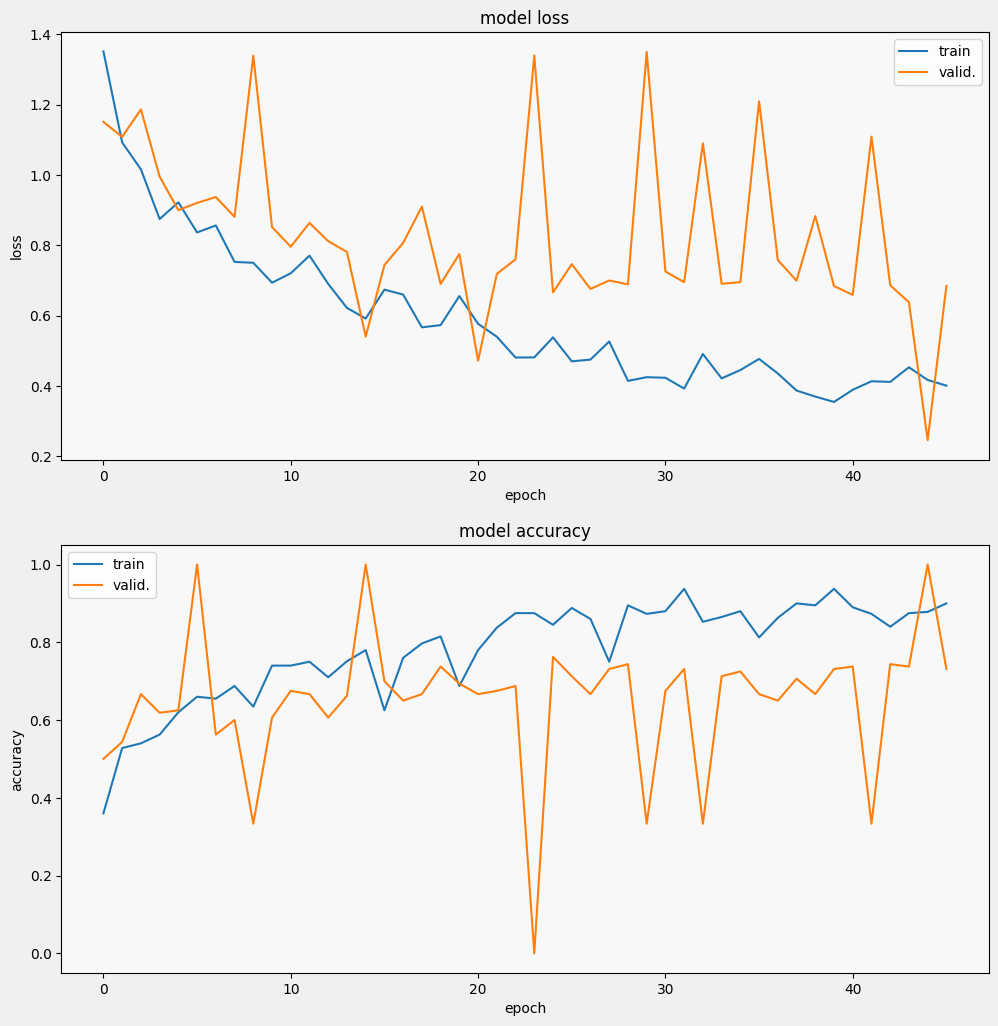

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [ ]:
model.save('/content/drive/MyDrive/Data/trained_lung_cancer_model_final.h5')


In [ ]:
model.save('trained_lung_cancer_model3321.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The image belongs to class: normal


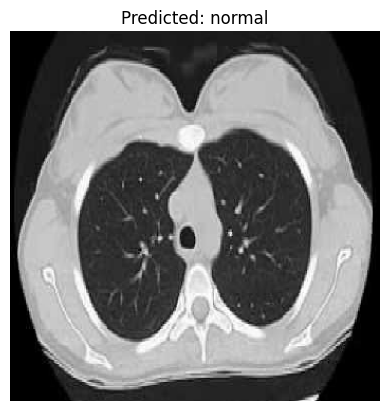

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(350,350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Data/train/normal/10.png'
img = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]]

  [[0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

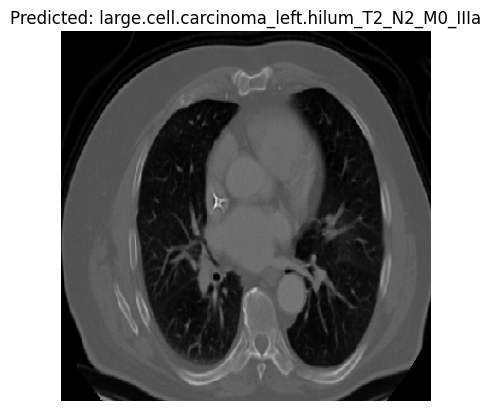

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(350,350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000016 (4).png'
img = load_and_preprocess_image(img_path)
print(img)
print("------------")

# Make a prediction
predictions = model.predict(img)
print(predictions)
print("------------")
predicted_class = np.argmax(predictions[0])
print(predicted_class)
print("------------")

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


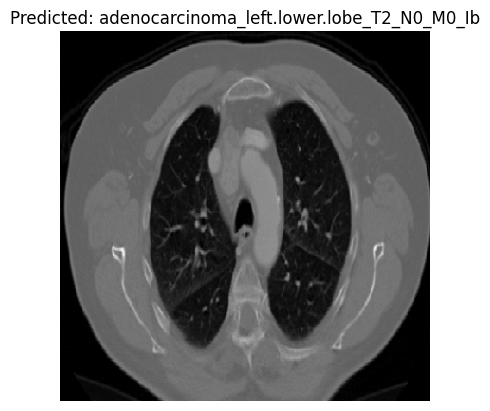

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(350,350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000000 (6).png'
img = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
The image belongs to class: normal


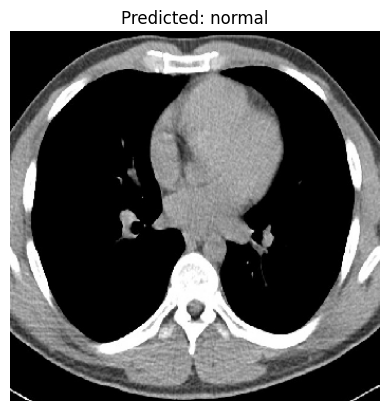

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(350,350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Data/valid/normal/4 (2).png'
img = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
The image belongs to class: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


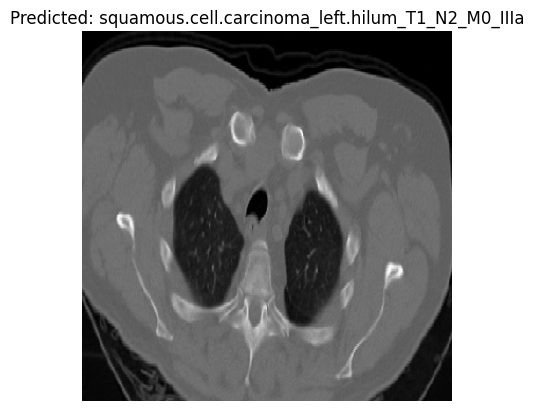

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(350,350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load an image from your drive
img_path = '/content/drive/MyDrive/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png'
img = load_and_preprocess_image(img_path)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step


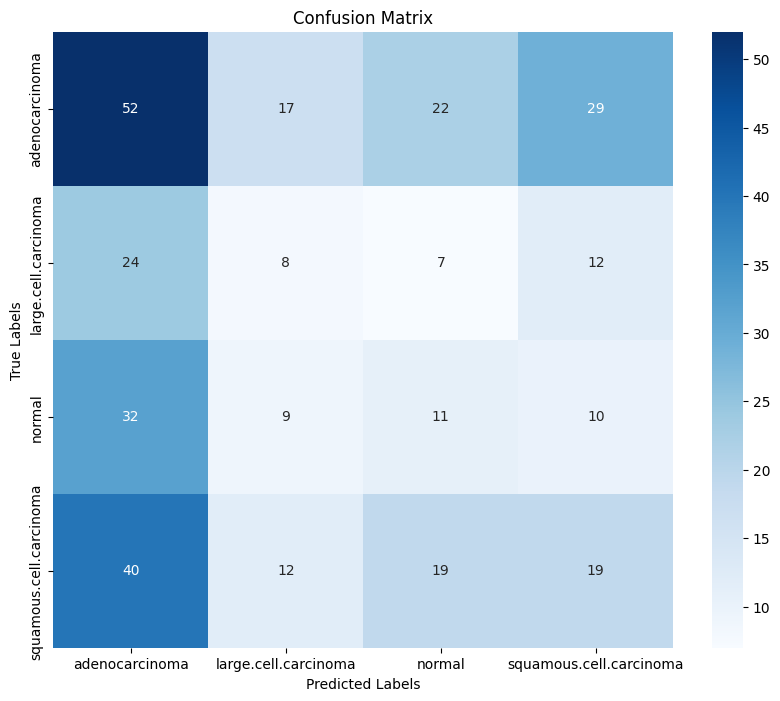

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the ground truth labels and the predicted labels
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels from the generator
y_true = validation_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
